In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

In [3]:
NAO_df = pd.read_csv("/norm.daily.nao.cdas.z500.19500101_current.csv")

In [4]:
# convert to datetime format and set as index
NAO_df['date'] = pd.to_datetime(NAO_df[['year', 'month', 'day']])
# Drop the individual year, month, day columns if needed
NAO_df.drop(columns=['year', 'month', 'day'], inplace=True)
NAO_df.set_index('date', inplace=True)

print(NAO_df)

            nao_index_cdas
date                      
1950-01-01        0.365000
1950-01-02        0.096000
1950-01-03       -0.416000
1950-01-04       -0.616000
1950-01-05       -0.261000
...                    ...
2024-05-11        0.688005
2024-05-12        0.517683
2024-05-13        0.520576
2024-05-14        0.357431
2024-05-15       -0.142666

[27164 rows x 1 columns]


In [5]:
# calculate monthly mean and adding to the datafram
# Calculate monthly mean
monthly_mean = NAO_df.resample('M').mean()

# Broadcast monthly mean to each day within the same month
monthly_mean_broadcasted = monthly_mean.reindex(NAO_df.index, method='bfill')

# Merge the broadcasted monthly mean back to the original DataFrame
NAO_df['monthly_mean'] = monthly_mean_broadcasted


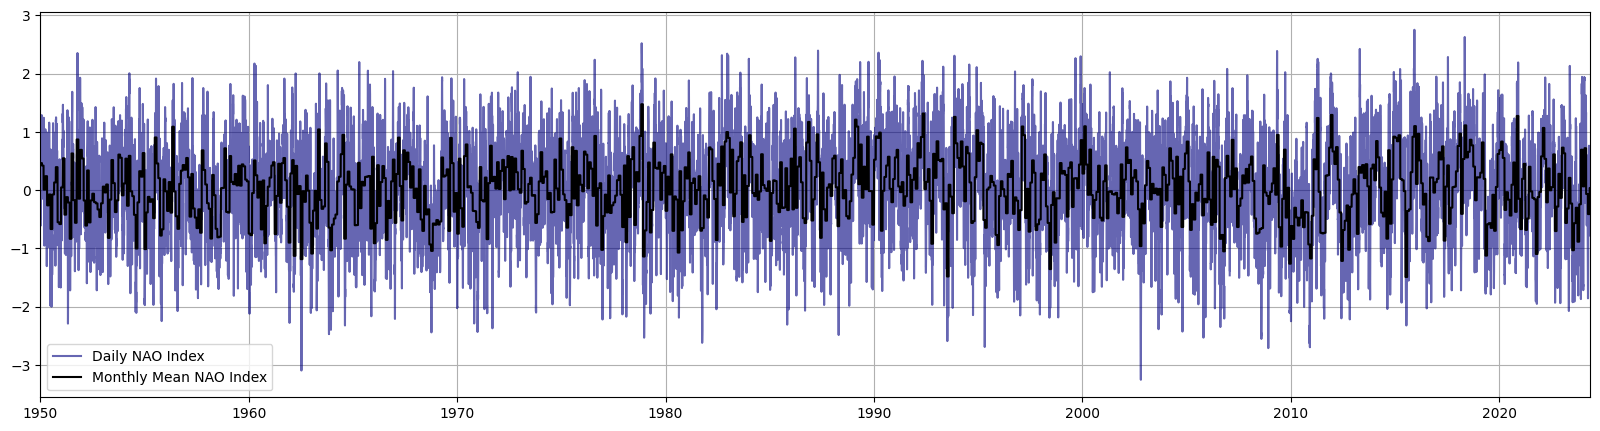

In [6]:
#simple visulization of the time series
plt.figure(figsize=[20,5])
plt.plot(NAO_df["nao_index_cdas"],alpha=0.6,label="Daily NAO Index",color="navy")
plt.plot(NAO_df["monthly_mean"],label="Monthly Mean NAO Index",color="k")
plt.xlim(-7305,19855)
plt.legend()
plt.grid()

## Stochastic Analysis

In [7]:
#check for missing values:
print("Found " + str(pd.isna(NAO_df["nao_index_cdas"].values).sum()) + " missing values in the dataframe.")

Found 2 missing values in the dataframe.


In [8]:
# Find missing values
np.where(pd.isna(NAO_df["nao_index_cdas"])==True)
print(NAO_df.index[[20752, 20844]])
# interpolate missing values
NAO_df["nao_index_cdas"] = NAO_df["nao_index_cdas"].interpolate(method='linear')

DatetimeIndex(['2006-10-26', '2007-01-26'], dtype='datetime64[ns]', name='date', freq=None)


In [9]:
# check again:
print("Found " + str(pd.isna(NAO_df["nao_index_cdas"].values).sum()) + " missing values in the dataframe.")

Found 0 missing values in the dataframe.


In [10]:
st.describe(NAO_df["nao_index_cdas"].values)

DescribeResult(nobs=27164, minmax=(-3.253999948501587, 2.75131893157959), mean=0.024639346337295344, variance=0.6627130825704843, skewness=-0.16469975520018598, kurtosis=-0.1831686359221565)

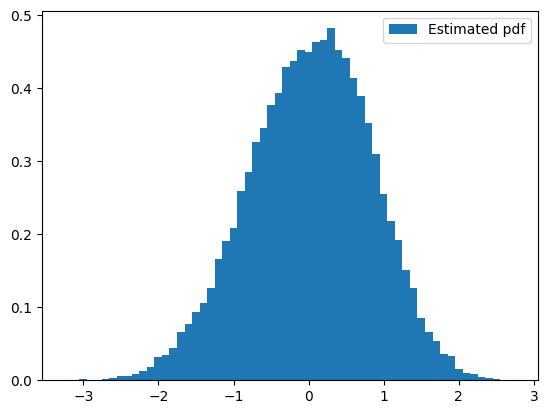

In [11]:
plt.hist(NAO_df["nao_index_cdas"],bins=60,density=True,label="Estimated pdf")
plt.legend()
plt.show()

In [ ]:
st.describe(NAO_df["nao_index_cdas"]["1950":"1980"])

DescribeResult(nobs=11323, minmax=(-3.095000028610229, 2.5199999809265137), mean=-0.025210809759961154, variance=0.6255226680459232, skewness=-0.14895231648517193, kurtosis=-0.22425763828848044)

In [ ]:
st.describe(NAO_df["nao_index_cdas"]["1980":"2009"])

DescribeResult(nobs=10958, minmax=(-3.253999948501587, 2.3940000534057617), mean=0.068958160738376, variance=0.6694916989023104, skewness=-0.23589712583723524, kurtosis=-0.06498461759629937)

In [ ]:
st.describe(NAO_df["nao_index_cdas"]["2010"])

DescribeResult(nobs=365, minmax=(-2.69617247581482, 1.1569489240646362), mean=-0.5796321871186517, variance=0.4429502599437567, skewness=-0.33112687504723515, kurtosis=0.36953782653447664)

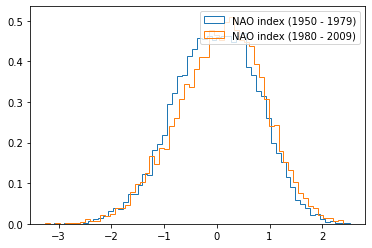

In [ ]:
plt.hist(NAO_df["nao_index_cdas"]["1950":"1979"],bins=60,histtype="step",density=True,label="NAO index (1950 - 1979)")
plt.hist(NAO_df["nao_index_cdas"]["1980":"2009"],bins=60,histtype="step",density=True,label="NAO index (1980 - 2009)")
#plt.hist(NAO_df["nao_index_cdas"]["2010":],bins=60,histtype="step",density=True,label="NAO index (2010 - 2024(May))")
plt.legend()
plt.show()

(0.0, 500.0)

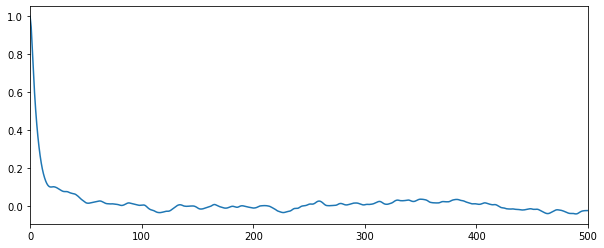

In [ ]:
# autocorrelation function:
autocorr_NAO = sm.tsa.acf(NAO_df["nao_index_cdas"], nlags=500)
plt.figure(figsize=[10,4])
plt.plot(autocorr_NAO)
plt.xlim(0,500)

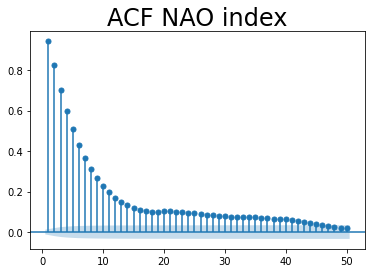

In [ ]:
import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(NAO_df["nao_index_cdas"], lags = 60, zero = False)
plt.title("ACF NAO index", size = 24)
plt.show()

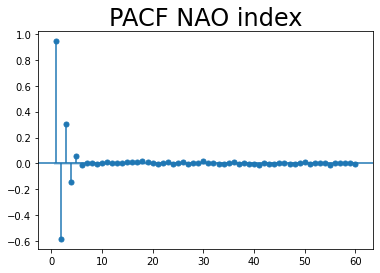

In [ ]:
sgt.plot_pacf(NAO_df["nao_index_cdas"], lags = 60, zero = False, method = ('ols'))
plt.title("PACF NAO index", size = 24)
plt.show()

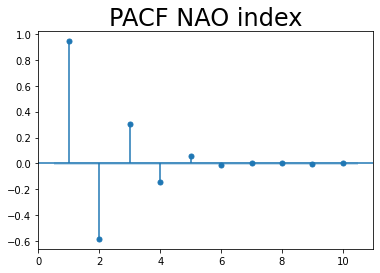

In [ ]:
sgt.plot_pacf(NAO_df["nao_index_cdas"], lags = 10, zero = False, method = ('ols'))
plt.title("PACF NAO index", size = 24)
plt.show()

In [ ]:
import statsmodels.tsa.stattools as sts
sts.adfuller(NAO_df["nao_index_cdas"])

(-26.939653200313437,
 0.0,
 18,
 27142,
 {'1%': -3.43059095197697,
  '5%': -2.8616464938489705,
  '10%': -2.5668266834976325},
 -8311.488489157477)

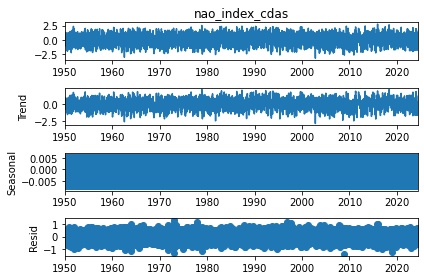

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_multiplicative = seasonal_decompose(NAO_df["nao_index_cdas"], model = "additive")
s_dec_multiplicative.plot()
plt.show()

## Power Spectral Analysis

In [ ]:
time = np.arange(0,len(monthly_mean))#*(60*60*24*30)
N = np.shape(monthly_mean)[0]
T = np.array(np.shape(time))
df = 1/T
f_vec = df * np.arange(int(N))[1:int(N/2)]


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


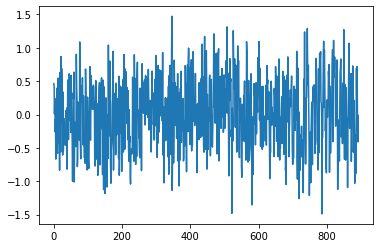

In [ ]:
plt.plot(fft_result)

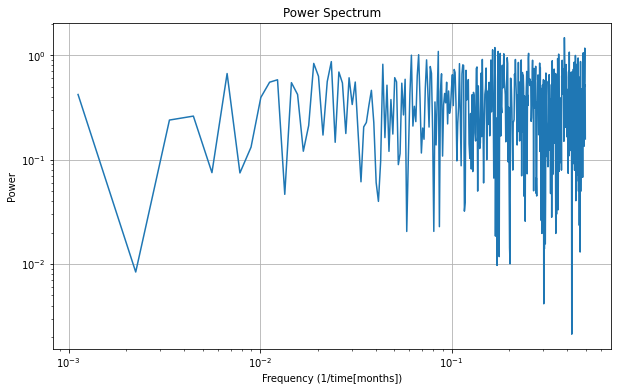

In [ ]:
# sprectral analysis
# Perform Fourier Transform (FFT)
fft_result = np.abs(np.fft.fft(monthly_mean))[1:int(N/2)]
#freq = np.fft.fftfreq(len(monthly_mean), d=1)  # Frequency bins in months

# Calculate power spectrum
#power_spectrum = np.abs(fft_result)**2

# Plot the results
plt.figure(figsize=(10, 6))
plt.loglog(f_vec, fft_result)
plt.title('Power Spectrum')
plt.xlabel('Frequency (1/time[months])')
plt.ylabel('Power')
plt.grid(True)
plt.show()

Ab hier erste NBeats prediction versuche

In [10]:
#Splitting Data for training and test data

split_date = pd.Timestamp('2021-01-01')
train_df = NAO_df[NAO_df.index < split_date]
test_df = NAO_df[NAO_df.index >= split_date]
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (25933, 2)
Testing data shape: (1231, 2)


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_df['nao_index_cdas'].values.reshape(-1, 1)).reshape(-1)
test_scaled = scaler.transform(test_df['nao_index_cdas'].values.reshape(-1, 1)).reshape(-1)

In [13]:
# Define a function to create sequences
def create_sequences(data, input_length):
    xs, ys = [], []
    for i in range(len(data)-input_length):
        x = data[i:(i+input_length)]
        y = data[i+1:(i+1+input_length)]
        xs.append(x)
        ys.append(y[-1])
    return np.array(xs), np.array(ys)

input_length = 12  # For example, using the past 12 months to predict the next month
X_train, y_train = create_sequences(train_scaled, input_length)
X_test, y_test = create_sequences(test_scaled, input_length)

# Reshape for model input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [1]:
import torch
from torch import nn
from nbeats_pytorch.model import NBeatsNet

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming you have defined the model architecture as per NBeatsNet requirements:
model = NBeatsNet(stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                        forecast_length=1,
                        backcast_length=input_length,
                        hidden_layer_units=64,
                        nb_blocks_per_stack=3,
                        device=device)

model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=12, forecast_length=1, share_thetas=False) at @138339758618128
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=12, forecast_length=1, share_thetas=False) at @138339796299600
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=12, forecast_length=1, share_thetas=False) at @138339796298880
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=12, forecast_length=1, share_thetas=False) at @138339796090256
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=12, forecast_length=1, share_thetas=False) at @138339796300512
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=12, forecast_length=1, share_thetas=False) at @138339796297680


In [16]:
# Convert your data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().unsqueeze(-1).to(device)
X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test).float().unsqueeze(-1).to(device)

In [23]:
#Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Unpack the model's output to separately get backcast and forecast; only use forecast for loss
    _, forecast = model(X_train_tensor)

    # Now, 'forecast' directly refers to the second tensor from the model's
    loss = criterion(forecast, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.6805214881896973
Epoch 10, Loss: 0.09039062261581421
Epoch 20, Loss: 0.05666894093155861
Epoch 30, Loss: 0.040134627372026443
Epoch 40, Loss: 0.028627626597881317
Epoch 50, Loss: 0.02118845097720623
Epoch 60, Loss: 0.015914488583803177
Epoch 70, Loss: 0.012823842465877533
Epoch 80, Loss: 0.010389397852122784
Epoch 90, Loss: 0.00869535468518734


In [24]:
# Switch model to evaluation mode
model.eval()

# No need to track gradients for prediction
with torch.no_grad():
    # Assuming your model outputs a tuple and we take the second element for prediction
    _, predictions = model(X_test_tensor)

In [25]:
# Ensure predictions are detached from the grad graph and moved to CPU for conversion to numpy
predictions_np = predictions.cpu().detach().numpy()

# Rescale the predictions back to the original scale
# Note: Ensure 'scaler' is the MinMaxScaler instance you used for scaling your data
predictions_rescaled = scaler.inverse_transform(predictions_np)

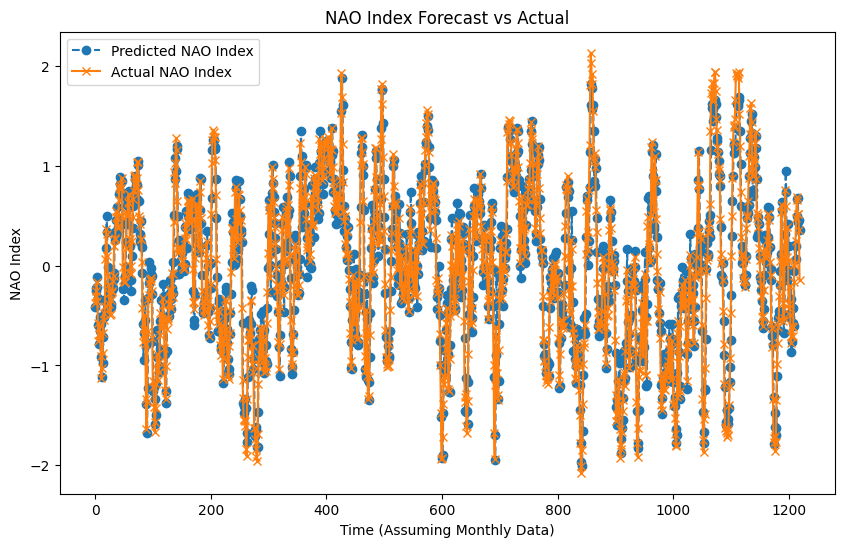

In [26]:
# You might need to adjust how you extract actual test values, particularly if they've been transformed
# Assuming y_test was your actual values tensor for the test set
y_test_np = y_test_tensor.cpu().detach().numpy()

# If the actual test data was also scaled, inversely transform these values too
y_test_rescaled = scaler.inverse_transform(y_test_np)

# Now, plotting
plt.figure(figsize=(10, 6))
plt.plot(predictions_rescaled, label='Predicted NAO Index', linestyle='--', marker='o')
plt.plot(y_test_rescaled, label='Actual NAO Index', marker='x')
plt.title('NAO Index Forecast vs Actual')
plt.xlabel('Time (Assuming Monthly Data)')
plt.ylabel('NAO Index')
plt.legend()
plt.show()

In [27]:
n_future_steps = 5  # Number of future steps you want to predict
future_predictions = []

# Start with the most recent known data sequence
current_sequence = X_test[-1:].reshape((1, X_test.shape[1], 1))  # Reshaping may vary based on your data

for step in range(n_future_steps):
    # Predict the next step
    with torch.no_grad():
        _, future_step_prediction = model(torch.tensor(current_sequence).float().to(device))
        future_predictions.append(future_step_prediction.cpu().numpy())

    # Update the current_sequence to include the new prediction
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[:, -1, :] = future_step_prediction.cpu().numpy()  # Update the last piece with the new prediction

# If data was normalized, inverse transform the predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Reshape appropriately for scaler.inverse_transform
future_predictions_rescaled = scaler.inverse_transform(future_predictions).flatten()

# future_predictions_rescaled now contains your future predictions in their original scale

In [30]:
import pandas as pd

# Assume NAO_df has a DateTimeIndex
last_date = NAO_df.index[-1]  # Gets the last date from your historical data

# Generating future dates starting from the next month of the last_date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(future_predictions_rescaled), freq='M')

# Creating a DataFrame for the future predictions
future_df = pd.DataFrame(future_predictions_rescaled, index=future_dates, columns=['Predicted_NAO_Index'])

# Concatenate the historical and future prediction DataFrames
full_df = pd.concat([NAO_df, future_df])

In [31]:
# Extracting last year's data from the historical DataFrame
last_year_data = NAO_df.last('12M')  # Adjust the '12M' if your data's frequency isn't monthly or to change the duration

# Alternatively, if the above method doesn't work as expected, you can manually specify the range
# last_year_date = NAO_df.index.max() - pd.DateOffset(months=12)
# last_year_data = NAO_df[last_year_date:]

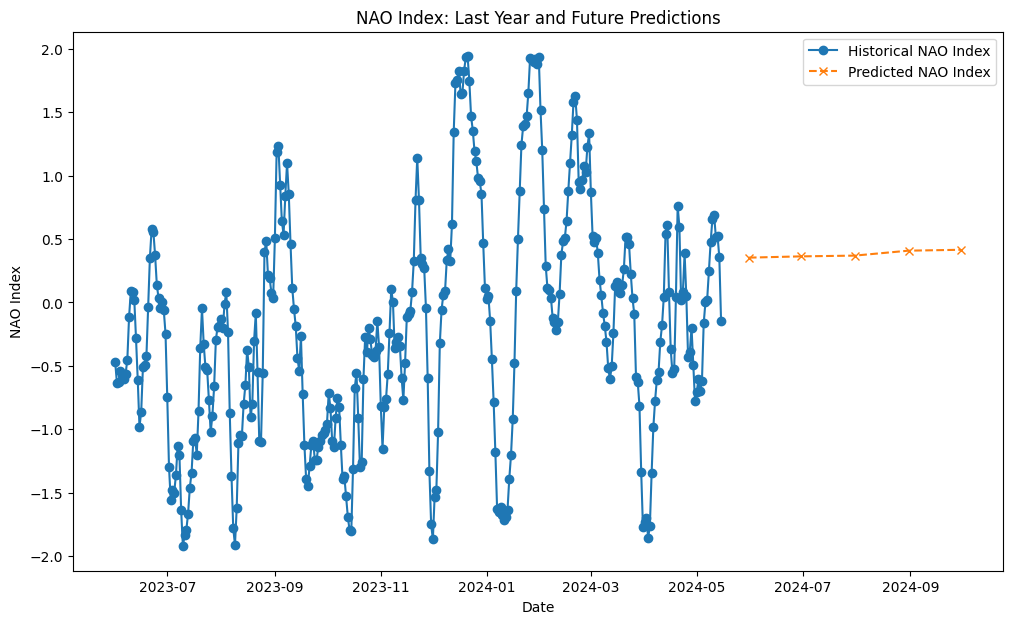

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Plotting the last year's historical data
plt.plot(last_year_data.index, last_year_data['nao_index_cdas'], label='Historical NAO Index', marker='o')

# Plotting the future predictions
plt.plot(future_df.index, future_df['Predicted_NAO_Index'], linestyle='--', label='Predicted NAO Index', marker='x')

plt.title('NAO Index: Last Year and Future Predictions')
plt.xlabel('Date')
plt.ylabel('NAO Index')
plt.legend()
plt.show()